In [6]:
# 07a – Standardized Rate Model (Approach 1)

# ---------------------------------------------------
# Step 1.1 – Imports & Raw-Folder Ingestion
# ---------------------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import re
from scipy import stats
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
sns.set_theme(style="whitegrid")

In [48]:
# Path to exported demand table from Notebook 06
demand_path = Path(
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed/demand_distributions/modality_demand_by_age_and_source.csv"
)
required_columns = {"age", "modality", "referral_type", "procedure_count"}

try:
    demand_df = pd.read_csv(demand_path)
    missing = required_columns - set(demand_df.columns)
    if missing:
        raise KeyError(f"Missing expected columns: {missing}")
    print(f"Loaded aggregated demand table: {len(demand_df):,} rows.")
    display(demand_df.head())
except (FileNotFoundError, KeyError) as e:
    print(f"Error loading demand table: {e}")
    demand_df = pd.DataFrame()

Loaded aggregated demand table: 1,293 rows.


,age,modality,referral_type,procedure_count
0,0.0,CT,Emergency,212
1,0.0,CT,GP,2
2,0.0,CT,Inpatient,443
3,0.0,CT,Other/Unknown,25
4,0.0,CT,Outpatient,103


In [49]:
# --------------------------------------------------------------
# 1.2 Load LSOA-Level Population Data (2024) – All ICBs (Wide Format)
# --------------------------------------------------------------
pop_path = Path(
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/all_icbs_2024.csv"
)
expected_base_cols = {"lsoa21cd", "ICB23NM", "total_population"}
expected_age_prefix = "age_"

if pop_path.exists():
    try:
        raw_df = pd.read_csv(pop_path)
        print(f"Loaded population data: {raw_df.shape[0]:,} rows × {raw_df.shape[1]} columns.")
        print("Columns:", list(raw_df.columns))
        missing_base = expected_base_cols - set(raw_df.columns)
        if missing_base:
            print("Warning: Missing expected base columns:", missing_base)
        age_cols = [col for col in raw_df.columns if col.startswith(expected_age_prefix)]
        if not age_cols:
            print("Error: No age segment columns found with prefix 'age_'.")
        else:
            print(f"Found {len(age_cols)} age segment columns.")
    except Exception as e:
        print("Error reading population file:", e)
        raw_df = pd.DataFrame()
else:
    print("Population file not found at path:", pop_path)
    raw_df = pd.DataFrame()


Loaded population data: 3,475 rows × 22 columns.
Columns: ['lsoa21cd', 'lsoa21nm', 'ICB23NM', 'total_population', 'age_0_4', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 'age_75_79', 'age_80_84', 'age_85_plus']
Found 18 age segment columns.


In [50]:
# --------------------------------------------------------------
# 1.3 Reshape LSOA Population: Wide → Long Format
# --------------------------------------------------------------
age_columns = [col for col in raw_df.columns if col.startswith("age_")]

pop_long_df = raw_df.melt(
    id_vars=["lsoa21cd"],
    value_vars=age_columns,
    var_name="age_band",
    value_name="population"
)
pop_long_df["age"] = pop_long_df["age_band"].str.extract(r"age_(\d+)_?")[0].astype(int)
pop_long_df = pop_long_df[["lsoa21cd", "age", "population"]]

print(f"Reshaped LSOA population table: {len(pop_long_df):,} rows.")
display(pop_long_df.head())


Reshaped LSOA population table: 62,550 rows.


,lsoa21cd,age,population
0,E01020484,0,43.76
1,E01020481,0,39.69
2,E01020482,0,70.21
3,E01020479,0,33.58
4,E01020478,0,37.65


In [51]:
# --------------------------------------------------------------
# 2.0 Standardized Rate Model – Join, Rate Calculation, Forecast
# --------------------------------------------------------------
# Aggregate national population by age
age_national_pop = pop_long_df.groupby("age", as_index=False).agg({"population": "sum"})

# Ensure consistent types
demand_df["age"] = demand_df["age"].astype(int)
age_national_pop["age"] = age_national_pop["age"].astype(int)

# Merge demand with national population to calculate rates
merged = pd.merge(demand_df, age_national_pop, how="left", on="age")
merged["rate_per_1000"] = merged["procedure_count"] / merged["population"] * 1000

print("Rates calculated (first few rows):")
display(merged.head())

# Forecast per LSOA: join rates onto LSOA pop, calculate expected demand
forecast_df = pd.merge(
    pop_long_df,
    merged[["age", "modality", "referral_type", "rate_per_1000"]],
    how="left",
    on="age"
)
forecast_df["predicted_procedures"] = forecast_df["population"] * forecast_df["rate_per_1000"] / 1000

print("Forecasted demand per LSOA (head):")
display(forecast_df.head())

# Aggregate to LSOA level by modality and referral type
lsoa_forecast = forecast_df.groupby(["lsoa21cd", "modality", "referral_type"], as_index=False).agg({
    "predicted_procedures": "sum"
})

print("Aggregated forecast by LSOA, modality, referral (head):")
display(lsoa_forecast.head())

Rates calculated (first few rows):


,age,modality,referral_type,procedure_count,population,rate_per_1000
0,0,CT,Emergency,212,283792.24,0.747025
1,0,CT,GP,2,283792.24,0.007047
2,0,CT,Inpatient,443,283792.24,1.561001
3,0,CT,Other/Unknown,25,283792.24,0.088093
4,0,CT,Outpatient,103,283792.24,0.362942


Forecasted demand per LSOA (head):


,lsoa21cd,age,population,modality,referral_type,rate_per_1000,predicted_procedures
0,E01020484,0,43.76,CT,Emergency,0.747025,0.032690
1,E01020484,0,43.76,CT,GP,0.007047,0.000308
2,E01020484,0,43.76,CT,Inpatient,1.561001,0.068309
3,E01020484,0,43.76,CT,Other/Unknown,0.088093,0.003855
4,E01020484,0,43.76,CT,Outpatient,0.362942,0.015882


Aggregated forecast by LSOA, modality, referral (head):


,lsoa21cd,modality,referral_type,predicted_procedures
0,E01014014,CT,Emergency,11.229803
1,E01014014,CT,GP,3.920863
2,E01014014,CT,Inpatient,8.955509
3,E01014014,CT,Other/Unknown,0.459550
4,E01014014,CT,Outpatient,19.318491


Number of nulls in modality_clean: 0


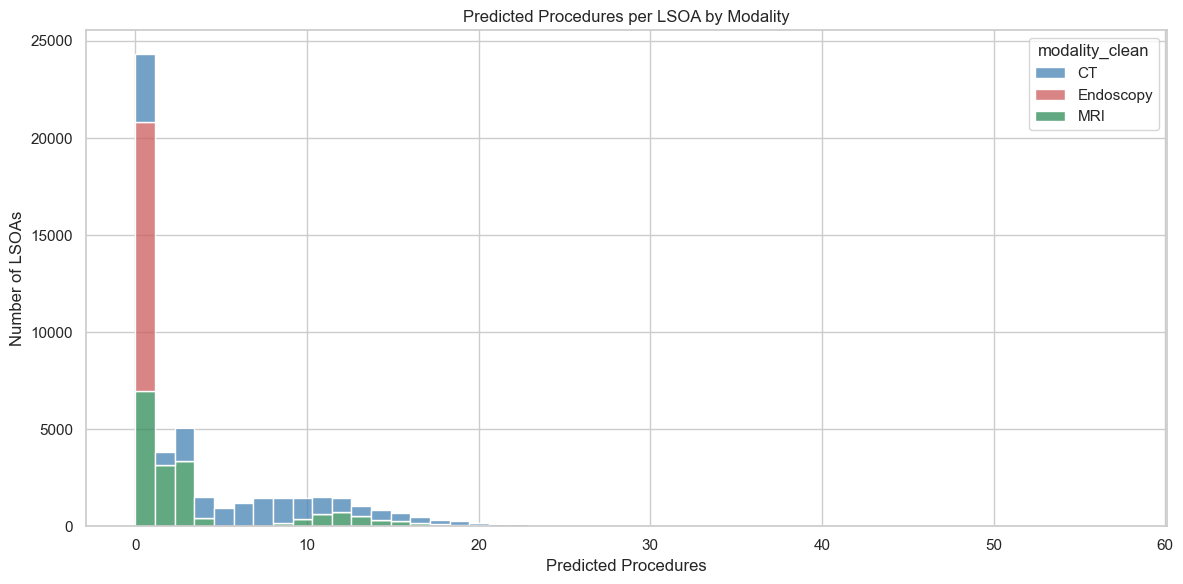

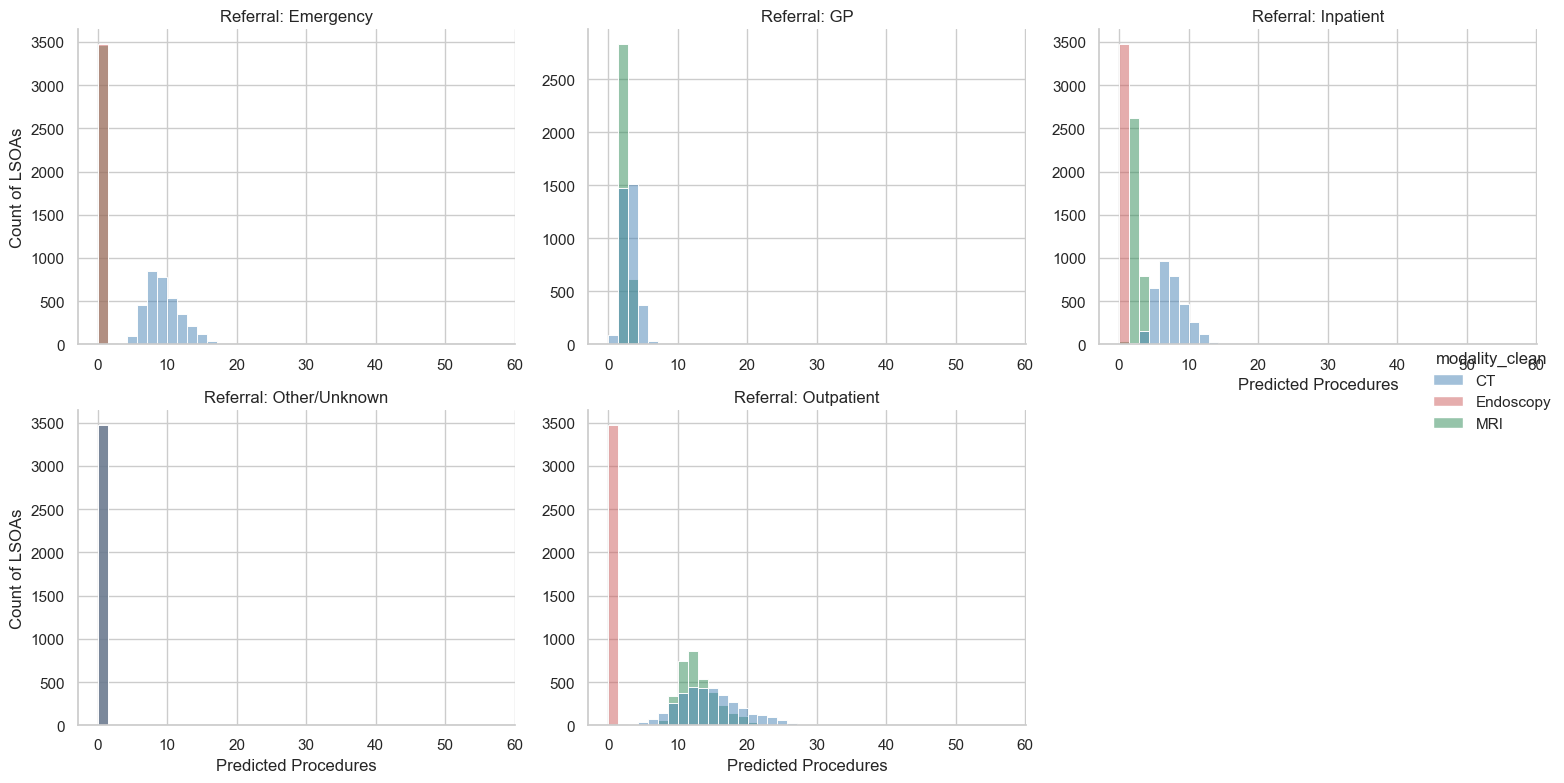

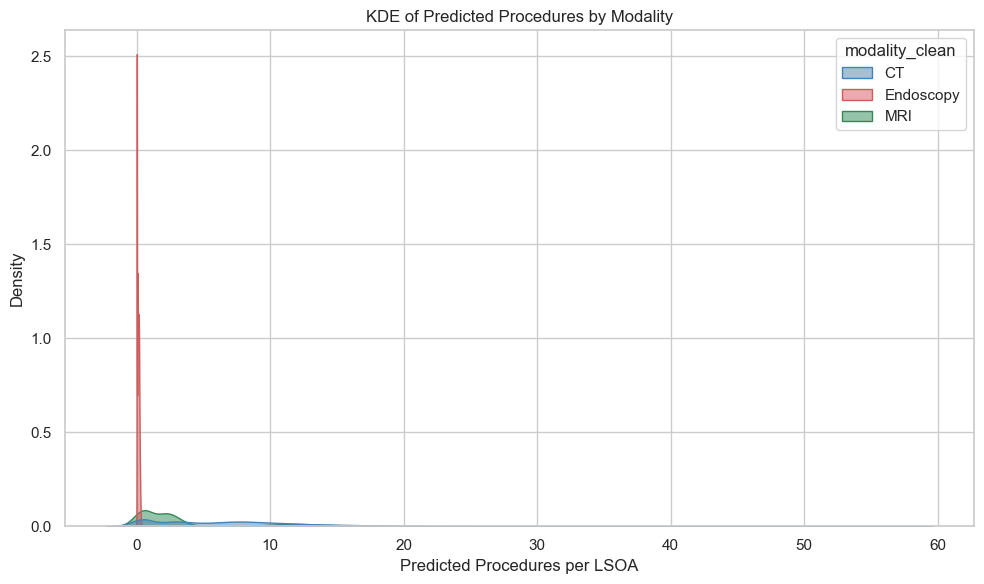

In [52]:
# --------------------------------------------------------------
# 2.5 Visualisations – Histograms by Modality and Referral Type
# --------------------------------------------------------------
# Map modality names if needed (adjust here if modality already clean)
modality_map = {
    'CT': 'CT',
    'MRI': 'MRI',
    'Endoscopy': 'Endoscopy'
}

lsoa_forecast['modality_clean'] = lsoa_forecast['modality'].map(modality_map)

# Check for null mapping results
num_null_mod = lsoa_forecast['modality_clean'].isna().sum()
print(f"Number of nulls in modality_clean: {num_null_mod}")
if num_null_mod > 0:
    print("Unmapped modality values:")
    print(lsoa_forecast.loc[lsoa_forecast['modality_clean'].isna(), 'modality'].unique())

# Filter data for plotting: remove NaNs and zero predicted procedures
plot_df = lsoa_forecast.dropna(subset=['predicted_procedures', 'modality_clean'])
plot_df = plot_df[plot_df['predicted_procedures'] > 0]

if plot_df.empty:
    raise ValueError("Nothing to plot – plot_df is empty after filtering.")

# Palette
modality_palette = {
    'CT': 'steelblue',
    'MRI': 'seagreen',
    'Endoscopy': 'indianred'
}

# Plot histogram by modality
plt.figure(figsize=(12, 6))
sns.histplot(
    data=plot_df,
    x='predicted_procedures',
    hue='modality_clean',
    palette=modality_palette,
    bins=50,
    multiple='stack'
)
plt.title("Predicted Procedures per LSOA by Modality")
plt.xlabel("Predicted Procedures")
plt.ylabel("Number of LSOAs")
plt.tight_layout()
plt.show()

# Faceted histogram by referral type
g = sns.displot(
    data=plot_df,
    x='predicted_procedures',
    col='referral_type',
    hue='modality_clean',
    palette=modality_palette,
    col_wrap=3,
    bins=40,
    facet_kws={'sharex': False, 'sharey': False},
    height=4,
    aspect=1.2
)
g.set_titles("Referral: {col_name}")
g.set_axis_labels("Predicted Procedures", "Count of LSOAs")
plt.tight_layout()
plt.show()

# KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=plot_df,
    x='predicted_procedures',
    hue='modality_clean',
    palette=modality_palette,
    fill=True,
    alpha=0.5
)
plt.title("KDE of Predicted Procedures by Modality")
plt.xlabel("Predicted Procedures per LSOA")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

Number of nulls in modality_clean: 13888
Unmapped modality values:
['Endoscopy']


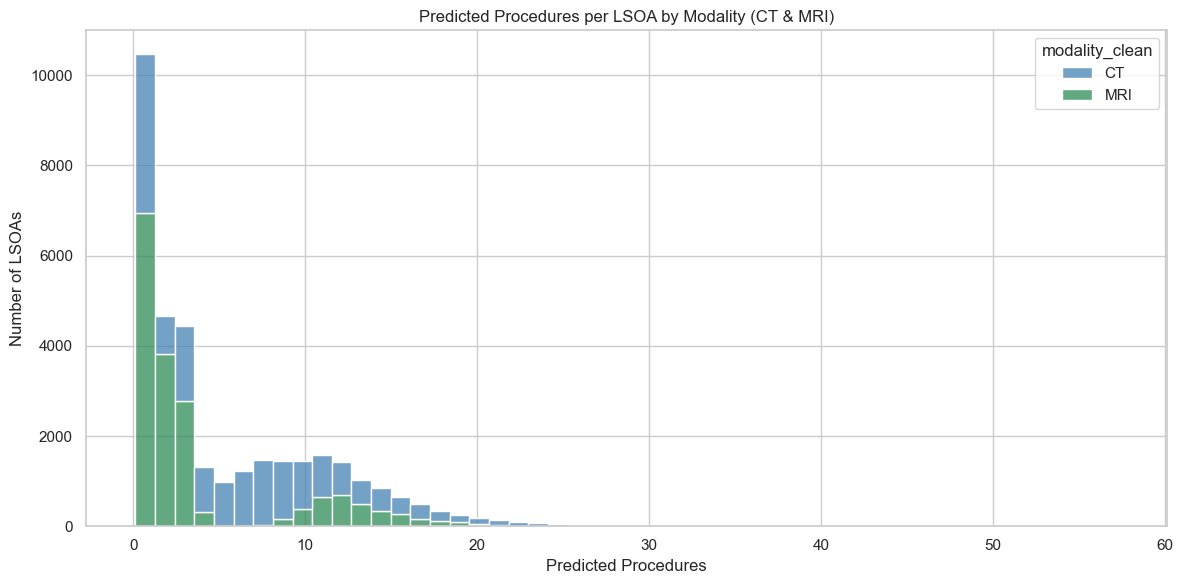

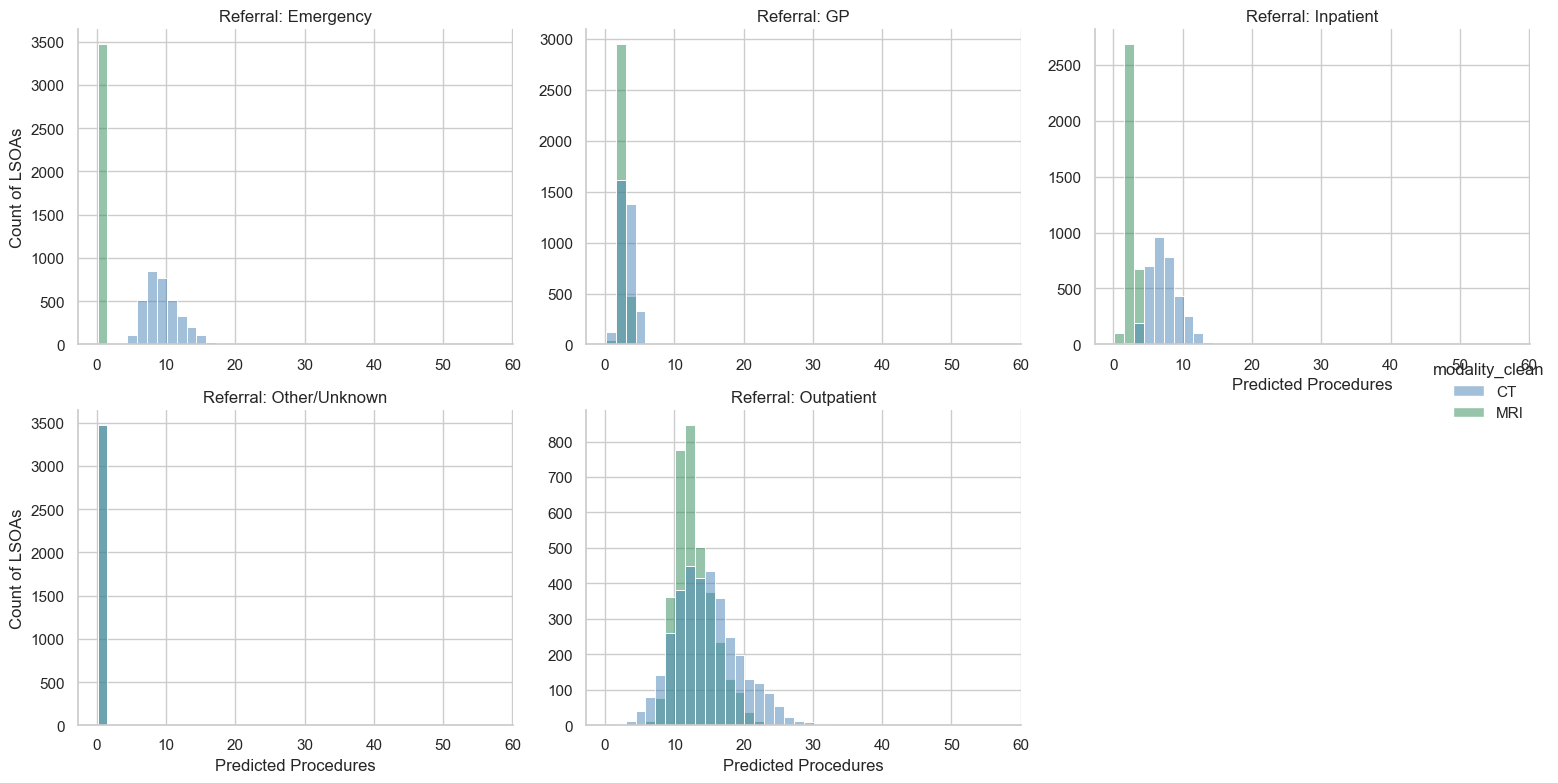

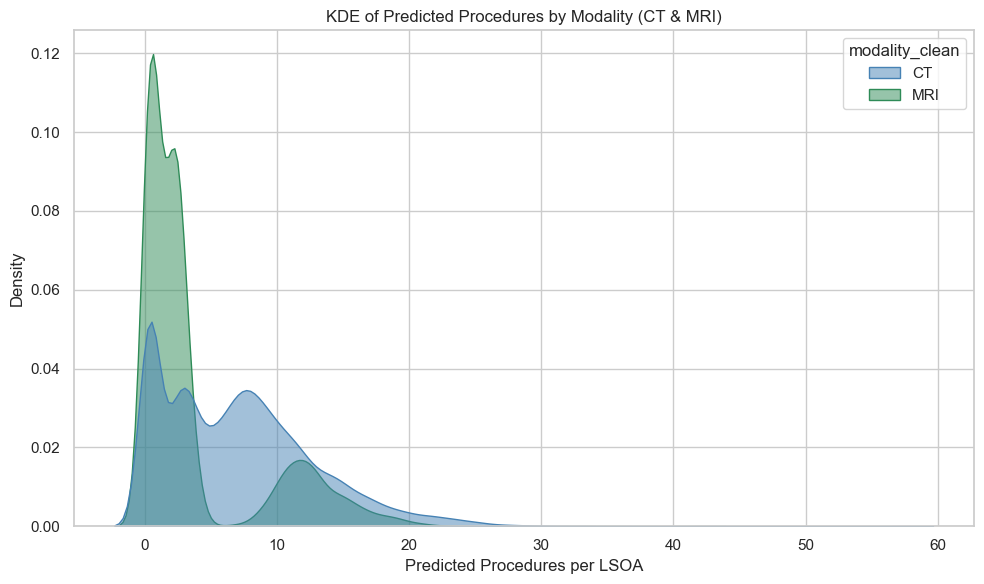

In [53]:
# --------------------------------------------------------------
# 2.6 Visualisations – Histograms by Modality and Referral Type (CT & MRI only)
# --------------------------------------------------------------
# Map modality names – keep only CT and MRI
modality_map = {
    'CT': 'CT',
    'MRI': 'MRI'
}

lsoa_forecast['modality_clean'] = lsoa_forecast['modality'].map(modality_map)

# Check for null mapping results
num_null_mod = lsoa_forecast['modality_clean'].isna().sum()
print(f"Number of nulls in modality_clean: {num_null_mod}")
if num_null_mod > 0:
    print("Unmapped modality values:")
    print(lsoa_forecast.loc[lsoa_forecast['modality_clean'].isna(), 'modality'].unique())

# Filter data for plotting: keep only CT and MRI, remove NaNs and zeros
plot_df = lsoa_forecast.dropna(subset=['predicted_procedures', 'modality_clean'])
plot_df = plot_df[plot_df['predicted_procedures'] > 0]
plot_df = plot_df[plot_df['modality_clean'].isin(['CT', 'MRI'])]

if plot_df.empty:
    raise ValueError("Nothing to plot – plot_df is empty after filtering.")

# Palette for CT and MRI only
modality_palette = {
    'CT': 'steelblue',
    'MRI': 'seagreen'
}

# Plot histogram by modality
plt.figure(figsize=(12, 6))
sns.histplot(
    data=plot_df,
    x='predicted_procedures',
    hue='modality_clean',
    palette=modality_palette,
    bins=50,
    multiple='stack'
)
plt.title("Predicted Procedures per LSOA by Modality (CT & MRI)")
plt.xlabel("Predicted Procedures")
plt.ylabel("Number of LSOAs")
plt.tight_layout()
plt.show()

# Faceted histogram by referral type
g = sns.displot(
    data=plot_df,
    x='predicted_procedures',
    col='referral_type',
    hue='modality_clean',
    palette=modality_palette,
    col_wrap=3,
    bins=40,
    facet_kws={'sharex': False, 'sharey': False},
    height=4,
    aspect=1.2
)
g.set_titles("Referral: {col_name}")
g.set_axis_labels("Predicted Procedures", "Count of LSOAs")
plt.tight_layout()
plt.show()

# KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=plot_df,
    x='predicted_procedures',
    hue='modality_clean',
    palette=modality_palette,
    fill=True,
    alpha=0.5
)
plt.title("KDE of Predicted Procedures by Modality (CT & MRI)")
plt.xlabel("Predicted Procedures per LSOA")
plt.ylabel("Density")
plt.tight_layout()
plt.show()
